# 🚗 Car Price Prediction Project

This notebook aims to predict car prices using machine learning using Regression models.

## 📦 Import Libraries

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import pickle
import warnings
warnings.filterwarnings('ignore')

## 🧾 Data Overview

In [45]:
df = pd.read_csv(r'C:\Users\Raymund\Downloads\Portfolio Projects\Python\Car Prices\car_prices.csv')
df.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


### Data Dictionary:

| Feature      | Description                                                    |
| :----------- | :------------------------------------------------------------- |
| `0. year`      | The manufacturing year of the vehicle.                         |
| `1. make`      | The brand or manufacturer of the vehicle.                      |
| `2. model`     | The specific model of the vehicle.                             |
| `3. trim`      | Additional designation for the vehicle model.                  |
| `4. body`      | The body type of the vehicle (e.g., SUV, Sedan).               |
| `5. transmission`| The type of transmission in the vehicle (e.g., automatic).   |
| `6. vin`       | Vehicle Identification Number, a unique code for each vehicle. |
| `7. state`     | The state where the vehicle is registered.                     |
| `8. condition` | Condition of the vehicle, possibly rated on a scale.           |
| `9. odometer`  | The mileage or distance traveled by the vehicle.               |
| `10. color`    | Exterior color of the vehicle.                                 |
| `11. interior` | Interior color of the vehicle.                                 |
| `12. seller`   | The entity selling the vehicle.                                |
| `13. mmr`      | Manheim Market Report, possibly indicating the estimated market value of the vehicle. |
| `14. sellingprice`| The price at which the vehicle was sold.                    |
| `15. saledate` | The date and time when the vehicle was sold.                   |


In [47]:
df.describe()

,year,condition,odometer,mmr,sellingprice
count,558837.000000,547017.000000,558743.000000,558799.000000,558825.000000
mean,2010.038927,30.672365,68320.017767,13769.377495,13611.358810
std,3.966864,13.402832,53398.542821,9679.967174,9749.501628
min,1982.000000,1.000000,1.000000,25.000000,1.000000
25%,2007.000000,23.000000,28371.000000,7100.000000,6900.000000
50%,2012.000000,35.000000,52254.000000,12250.000000,12100.000000
75%,2013.000000,42.000000,99109.000000,18300.000000,18200.000000
max,2015.000000,49.000000,999999.000000,182000.000000,230000.000000


## 🔍 Data Inspection
- Check for Duplicated rows
- Handle Null or Missingvalues
- Check mismatched data types
- Check and handle Outliers

In [48]:
# Check duplicated data
df.duplicated().sum()

0

**Duplicated Data summary:** There are no duplicated lines.

In [49]:
# Check percentage of missing/null data.
df.isna().mean()*100

year             0.000000
make             1.843292
model            1.860829
trim             1.905922
body             2.361154
transmission    11.694287
vin              0.000716
state            0.000000
condition        2.115107
odometer         0.016821
color            0.134028
interior         0.134028
seller           0.000000
mmr              0.006800
sellingprice     0.002147
saledate         0.002147
dtype: float64

In [50]:
# Drop rows with missing/null values
df1 = df.dropna()

**Missing Data summary:**
- at max, ~11.6% of rows are missing and will be significant to the result
- We will drop the rows of missing/null values

## ⚙️ Feature Engineering

In [51]:
# Create new column 'Car age' and 'miles/year'
# Car Age - the difference between the year in 'saledate' column and the 'Year' column.
# miles/year - the result of 'odometer' over the 'Car age', this is the average miles run by the car per year. 

import re

def extract_year_from_object(text):
    """Extracts the first four-digit year from a string."""
    match = re.search(r'(\d{4})', str(text))
    if match:
        return int(match.group(1))
    return None 

# Apply the function to create the 'Year sold' column
df1['Year sold'] = df1['saledate'].apply(extract_year_from_object)
df1['Car Age'] = df1['Year sold'] - df1['year']
df1['miles/year'] = df1.apply(lambda row: row['odometer'] if row['Car Age'] == 0 else row['odometer'] / row['Car Age'], axis=1)

## 📊 Exploratory Data Analysis (EDA)

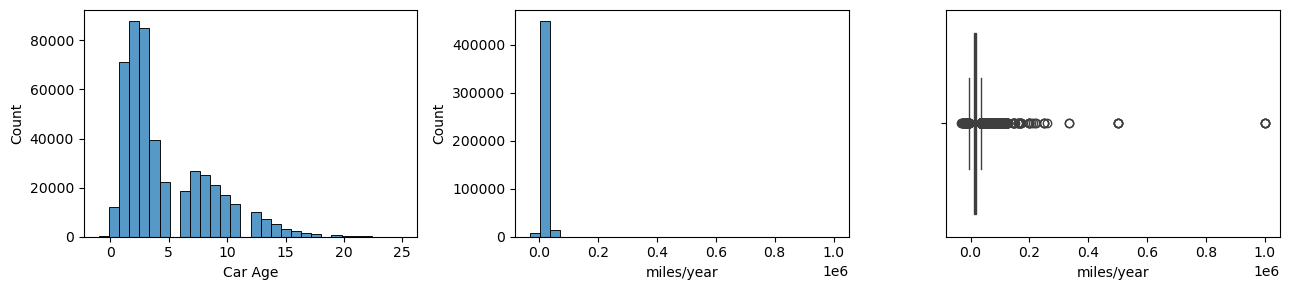

In [52]:
# Visualize new column - 'Car age' and 'miles/year'
fig, axes = plt.subplots(ncols = 3, figsize=(13,3))

sns.histplot(df1['Car Age'], bins = 30, ax=axes[0])
sns.histplot(df1['miles/year'], bins = 30, ax=axes[1])
sns.boxplot(x=df1['miles/year'], ax=axes[2])

plt.tight_layout()
plt.show()

There seems to be an invalid input from miles/year and Car Age which resulted to negative value. Need to validate further.

In [53]:
# Validate negative outliers from 'Car Age' and 'miles/year' column
df1[['Car Age', 'miles/year']].describe()

,Car Age,miles/year
count,472325.000000,472325.000000
mean,4.711131,16232.583019
std,3.819604,9772.666132
min,-1.000000,-31043.000000
25%,2.000000,10244.250000
50%,3.000000,14108.666667
75%,7.000000,19989.000000
max,25.000000,999999.000000


Validated the negative outlier which is an invalid data as there should be no negative value of 'Car Age'. It is necessary to remove these data as they are invalid entry.

In [54]:
# Remove negative outliers in Car Age
df2 = df1[(df1['Car Age'] >=0) & (df1['miles/year'] >=0)]

# Validate 'Car Age' and 'miles/year' column
df2[['Car Age', 'miles/year']].describe()

,Car Age,miles/year
count,472168.000000,472168.000000
mean,4.713030,16241.997334
std,3.818819,9759.801037
min,0.000000,0.040000
25%,2.000000,10248.245192
50%,3.000000,14111.062500
75%,7.000000,19991.275000
max,25.000000,999999.000000


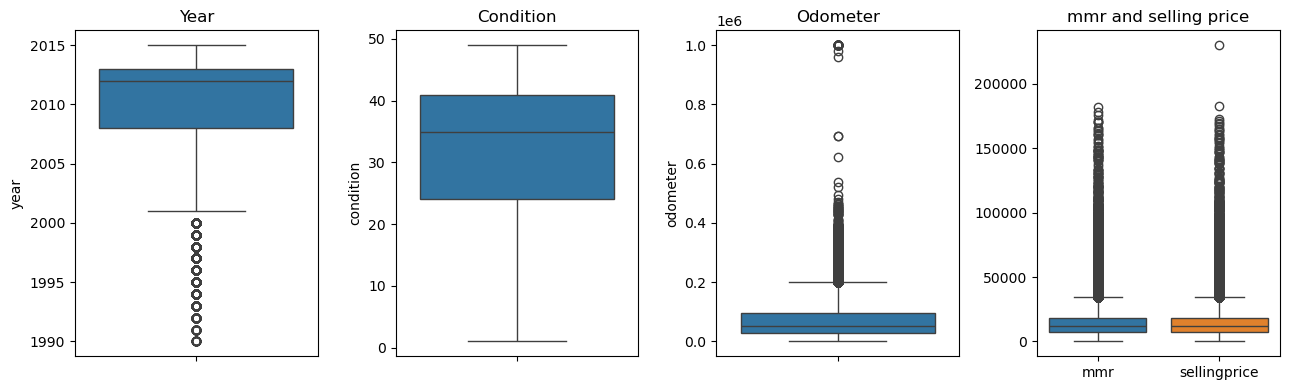

In [55]:
# Visualize other outliers in numerical columns through box plots
cols = ['year', 'condition', 'odometer']
titles = ['Year', 'Condition', 'Odometer']

fig, axes = plt.subplots(1, 4, figsize=(13, 4))

# Plot individual boxplots
for i, (col, title) in enumerate(zip(cols, titles)):
    sns.boxplot(y=df1[col], ax=axes[i])
    axes[i].set_title(title)

# Combined boxplot
sns.boxplot(data=df2[['mmr', 'sellingprice']], ax=axes[3])
axes[3].set_title('mmr and selling price')

plt.tight_layout()
plt.show()

**Result:** 
- No outlier can be seen in Condition
- Year column has a few outlier, but it seems to be a valid data with range from 1982 to 2015
- *Need to verify outliers in odometer and in mmr/selling price*

In [56]:
# Check outliers in odometer
df_odocheck = df2[['odometer', 'Car Age', 'sellingprice', 'make']]
df_odocheck.sort_values(by='odometer', ascending = False).head(10)

,odometer,Car Age,sellingprice,make
338793,999999.0,4,700.0,Ford
13568,999999.0,6,5500.0,Dodge
117926,999999.0,10,1100.0,Nissan
452275,999999.0,19,350.0,Chrysler
13480,999999.0,5,1700.0,Dodge
275,999999.0,2,2500.0,Hyundai
489833,999999.0,7,1200.0,Chrysler
476593,999999.0,8,2250.0,Buick
477255,999999.0,13,900.0,Ford
418607,999999.0,4,4000.0,Nissan


**Result:** Let's assume that all data in odometer is valid, but there is a single entity that might need to be reviewed after the modeling which is the <u>Kia with Car Age of 1 in index 385721<u>.

- Move forward to check the outlier in selling price column

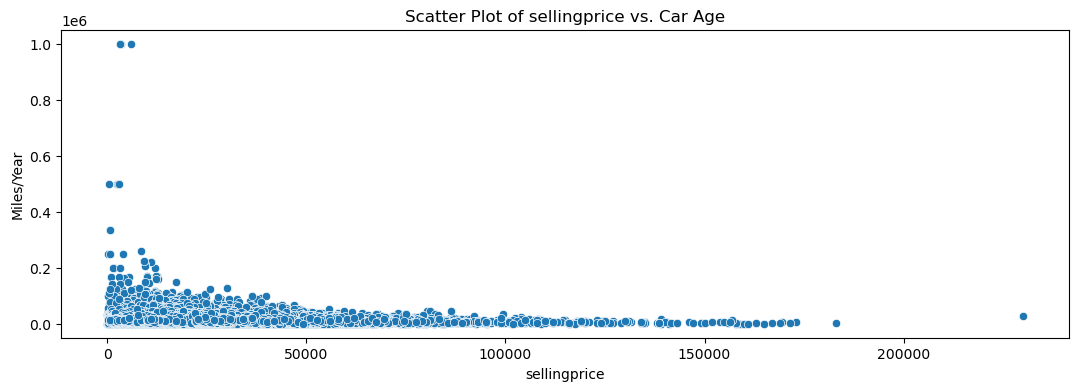

In [57]:
# Visualize selling price to car age thru scatter plot
plt.figure(figsize=(13, 4))
sns.scatterplot(x='sellingprice', y='miles/year', data=df2)
plt.title('Scatter Plot of sellingprice vs. Car Age')
plt.xlabel('sellingprice')
plt.ylabel('Miles/Year')
plt.show()

In [103]:
# Check details of the outlier in selling price column 
df_odocheck = df2[['odometer', 'sellingprice', 'make', 'model']]
df_odocheck.sort_values(by='sellingprice', ascending = False).head(15)

,odometer,sellingprice,make,model
344905,27802.0,230000.0,Ford,Escape
548169,12116.0,183000.0,Ferrari,458 Italia
446949,5277.0,173000.0,Mercedes-Benz,S-Class
545523,7852.0,171500.0,Rolls-Royce,Ghost
125095,14316.0,169500.0,Rolls-Royce,Ghost
557570,11832.0,169000.0,Rolls-Royce,Ghost
538347,5215.0,167000.0,Rolls-Royce,Ghost
283534,154.0,165000.0,BMW,i8
146917,60.0,165000.0,BMW,i8
194349,12912.0,163000.0,Rolls-Royce,Ghost


**Result:** Checking the selling price, all seems to be valid aside from the top outlier in selling price which is a **Ford Escape sold at $230k**. 

We will drop this row indexed at 344905. as this is an invalid data

In [60]:
# Drop selling price outlier
df3 = df2.copy()
df3.drop(index=344905, inplace=True)

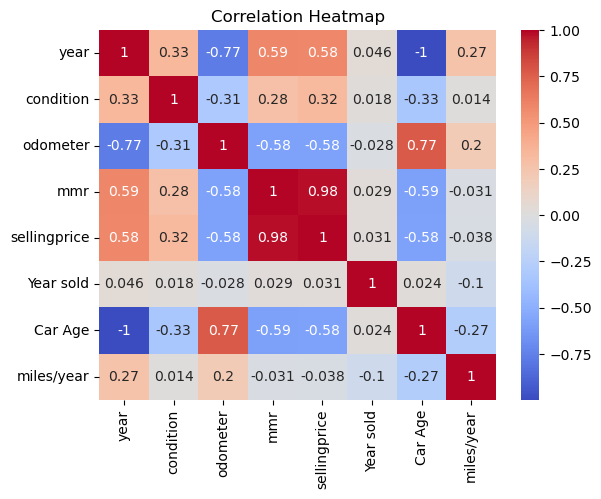

In [67]:
# Check correlation heatmap (numeric columns only)
sns.heatmap(df3.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

**Result:** mmr is highly correlated with selling price, including it in the model would likely make the model overly reliant on it, possibly masking the effects of other features. 

Actions is to <u>drop the mmr column<u>.

## 🧪 Train/Test Split
Isolate the dependent and independent variables

In [61]:
# Define X0 datafrane while the columns are still not encoded
X0 = df3.drop(['vin', 'saledate', 'sellingprice', 'seller', 'mmr'], axis = 1)
y = df3['sellingprice']

In [62]:
X0.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,Year sold,Car Age,miles/year
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,45.0,1331.0,gray,black,2015,1,1331.0
3,2015,Volvo,S60,T5,Sedan,automatic,ca,41.0,14282.0,white,black,2015,0,14282.0
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,ca,43.0,2641.0,gray,black,2014,0,2641.0
6,2014,BMW,M5,Base,Sedan,automatic,ca,34.0,14943.0,black,black,2014,0,14943.0
7,2014,Chevrolet,Cruze,1LT,Sedan,automatic,ca,2.0,28617.0,black,black,2014,0,28617.0


In [73]:
# Encode using one-hot encoding.
X = pd.get_dummies(X0)
X.shape

(472167, 2479)

Number pf columns have ballooned to 472K+\
We will run two models with different encoding techniques to validate the results.

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
rf_model = RandomForestRegressor(random_state=42)

## 🤖 Random Forest Regression Model (using one-hot encoding)

In [ ]:
#rf = rf_model.fit(X_test, y_test)

In [ ]:
## with open('vehicle_price_prediction_rf.pkl', 'wb') as f:
##    pickle.dump(rf, f)

In [76]:
# Reload fitted model
with open('vehicle_price_prediction_rf.pkl', 'rb') as f:
    rf = pickle.load(f)

## 📈 Model Evaluation - RF model using one-hot encoding

In [108]:
# Print model metrics results
y_pred_rf = rf.predict(X_test)

print('R2: ', r2_score(y_test, y_pred_rf))
print('MSE: ', mean_squared_error(y_test, y_pred_rf))
print('MAE: ', mean_absolute_error(y_test, y_pred_rf))

R2:  0.9893884326365949
MSE:  964172.6304613975
MAE:  549.9263502552046


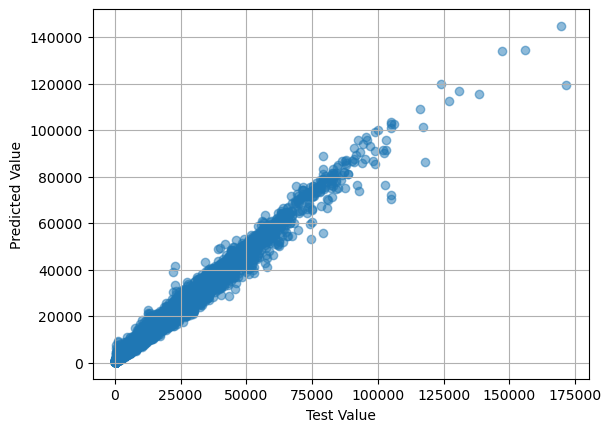

In [81]:
# Visualize results of predicated and test values
plt.scatter(x=y_test, y=y_pred_rf, alpha=0.5)
plt.xlabel('Test Value')
plt.ylabel('Predicted Value')
plt.grid(which='both')
plt.show()

**Result:**
- MSE:  964,172.63
- MAE:  549.92
- R2:  0.989

An R² value of 0.989 indicates that the model explains approximately 98.9% of the variance in the selling price, which signifies a highly accurate model. The relatively low MAE of 549.92 implies that, on average, the model’s predictions deviate from actual prices by just around $550, which is well within an acceptable range for vehicle pricing.

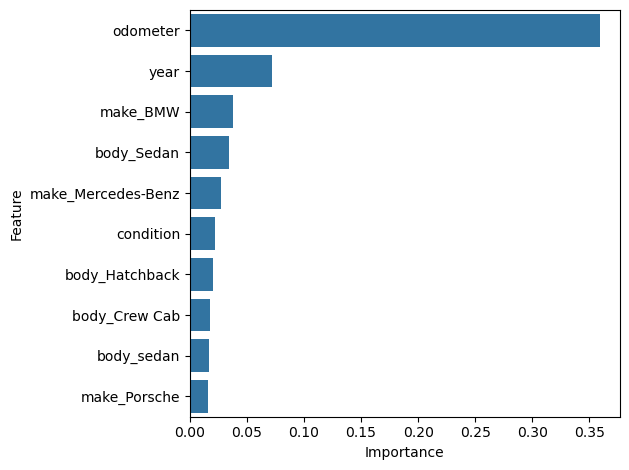

In [120]:
# Verify feature importance
importances_rf = rf.feature_importances_
feature_names_rf = rf.feature_names_in_

feat_imp_rf = pd.DataFrame({
    'Feature': feature_names_rf,
    'Importance': importances_rf
})

top_feats_rf = feat_imp_rf.sort_values(by='Importance', ascending=False).head(10)

sns.barplot(x='Importance', y='Feature', data=top_feats)
plt.tight_layout()
plt.show()

## ✅ RF model result and Recommendations

Based from feature importance, mileage is king, followed by the vehicle's year. Brand (BMW, Mercedes-Benz) and body type (Sedan) also hold considerable sway, while other factors like condition, hatchback, crew cab, and even Porsche make have comparatively minor but still present impacts on the model's predictions.

Actions: Feature importance have been divided to odometer, year and was subdivided thru specific make and body. <u>Verify the feature importance using label encoding.<u>

## 🤖🤖 Random Forest Regression Model (using label encoding)

In [84]:
X0.head(2)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,Year sold,Car Age,miles/year
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,45.0,1331.0,gray,black,2015,1,1331.0
3,2015,Volvo,S60,T5,Sedan,automatic,ca,41.0,14282.0,white,black,2015,0,14282.0


In [85]:
# use labelencoder to transform columns with categorical values
le = LabelEncoder()
X1 = X0.copy()
X1['make'] = le.fit_transform(X0['make'])
X1['model'] = le.fit_transform(X0['model'])
X1['trim'] = le.fit_transform(X0['trim'])
X1['body'] = le.fit_transform(X0['body'])
X1['transmission'] = le.fit_transform(X0['transmission'])
X1['state'] = le.fit_transform(X0['state'])
X1['color'] = le.fit_transform(X0['color'])
X1['interior'] = le.fit_transform(X0['interior'])
X1.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,Year sold,Car Age,miles/year
2,2014,3,8,253,36,0,2,45.0,1331.0,7,1,2015,1,1331.0
3,2015,51,575,1212,36,0,2,41.0,14282.0,17,1,2015,0,14282.0
4,2014,3,33,335,36,0,2,43.0,2641.0,7,1,2014,0,2641.0
6,2014,3,406,389,36,0,2,34.0,14943.0,1,1,2014,0,14943.0
7,2014,7,186,47,36,0,2,2.0,28617.0,1,1,2014,0,28617.0


In [106]:
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

In [ ]:
##rf_le = rf_model.fit(X1_train, y_train)

In [ ]:
##with open('vehicle_price_prediction_rf_le.pkl', 'wb') as f:
##    pickle.dump(rf_le, f)

In [88]:
with open('vehicle_price_prediction_rf_le.pkl', 'rb') as f:
    rf_le = pickle.load(f)

## 📈 Model Evaluation - RF model using label encoding

In [107]:
# Print model metrics results
y_pred_rf_le = rf_le.predict(X1_test)

print('R2: ', r2_score(y_test, y_pred_rf_le))
print('MSE: ', mean_squared_error(y_test, y_pred_rf_le))
print('MAE: ', mean_absolute_error(y_test, y_pred_rf_le))

R2:  0.9418946586658926
MSE:  5279482.0858571725
MAE:  1277.0916706376938


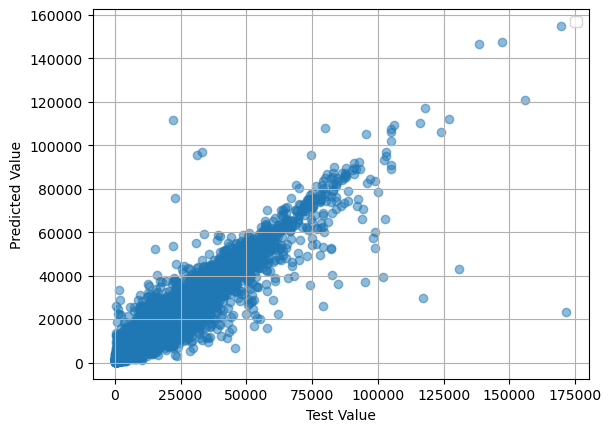

In [101]:
# Visualize results of predicated and test values
plt.scatter(x=y_test, y=y_pred_rf_le, alpha=0.5)
plt.xlabel('Test Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.grid(which='both')
plt.show()

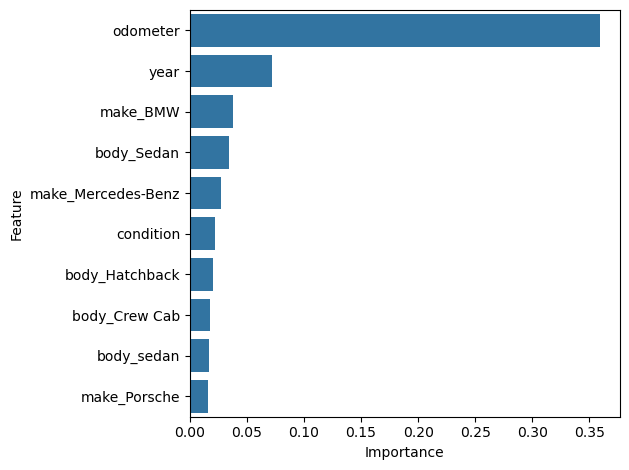

In [119]:
# Verify feature importance
importances_rf_le = rf_le.feature_importances_
feature_names_rf_le = rf_le.feature_names_in_

feat_imp_rf_le = pd.DataFrame({
    'Feature': feature_names_rf_le,
    'Importance': importances_rf_le
})

top_feats_rf_le = feat_imp_rf_le.sort_values(by='Importance', ascending=False).head(10)

sns.barplot(x='Importance', y='Feature', data=top_feats)
plt.tight_layout()
plt.show()

## ✅ Conclusion


In [111]:
# --- Calculate Metrics for RF Model (Label Encoded) ---
r2_le = r2_score(y_test, y_pred_rf_le)
mse_le = mean_squared_error(y_test, y_pred_rf_le)
rmse_le = np.sqrt(mse_le) # Root Mean Squared Error
mae_le = mean_absolute_error(y_test, y_pred_rf_le)
medae_le = median_absolute_error(y_test, y_pred_rf_le) # Median Absolute Error

# --- Calculate Metrics for RF Model (One-Hot Encoded) ---
r2_ohe = r2_score(y_test, y_pred_rf)
mse_ohe = mean_squared_error(y_test, y_pred_rf)
rmse_ohe = np.sqrt(mse_ohe) # Root Mean Squared Error
mae_ohe = mean_absolute_error(y_test, y_pred_rf)
medae_ohe = median_absolute_error(y_test, y_pred_rf) # Median Absolute Error

# --- Summarize Metrics in a DataFrame for Side-by-Side Comparison ---
print("--- Comprehensive Model Metrics Comparison ---")

metrics_data = {
    'Metric': ['R2 Score', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'Median Absolute Error (MedAE)'],
    'RF (Label Encoded)': [r2_le, mse_le, rmse_le, mae_le, medae_le],
    'RF (One-Hot Encoded)': [r2_ohe, mse_ohe, rmse_ohe, mae_ohe, medae_ohe]
}

df_metrics = pd.DataFrame(metrics_data)
df_metrics = df_metrics.set_index('Metric')

df_metrics_formatted = df_metrics.copy()
df_metrics_formatted.loc['R2 Score'] = df_metrics_formatted.loc['R2 Score'].map('{:.6f}'.format)
df_metrics_formatted.loc[['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'Median Absolute Error (MedAE)']] = \
    df_metrics_formatted.loc[['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'Median Absolute Error (MedAE)']].map('{:.2f}'.format)

print(df_metrics_formatted)

--- Comprehensive Model Metrics Comparison ---
                               RF (Label Encoded) RF (One-Hot Encoded)
Metric                                                                
R2 Score                                 0.941895             0.989388
Mean Squared Error (MSE)               5279482.09            964172.63
Root Mean Squared Error (RMSE)            2297.71               981.92
Mean Absolute Error (MAE)                 1277.09               549.93
Median Absolute Error (MedAE)              796.00               335.00


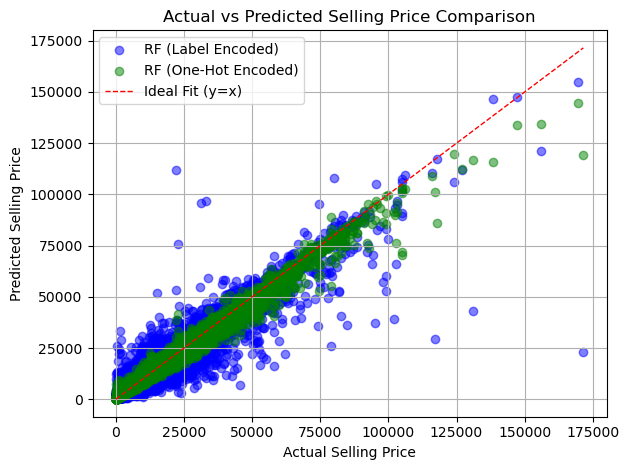

In [113]:
# Add labels to each scatter plot
plt.scatter(x=y_test, y=y_pred_rf_le, alpha=0.5, label='RF (Label Encoded)', color='blue')
plt.scatter(x=y_test, y=y_pred_rf, alpha=0.5, label='RF (One-Hot Encoded)', color='green')

# Add a reference line y = x for perfect predictions
min_val = min(y_test.min(), y_pred_rf.min(), y_pred_rf_le.min())
max_val = max(y_test.max(), y_pred_rf.max(), y_pred_rf_le.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=1, label='Ideal Fit (y=x)')

plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs Predicted Selling Price Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


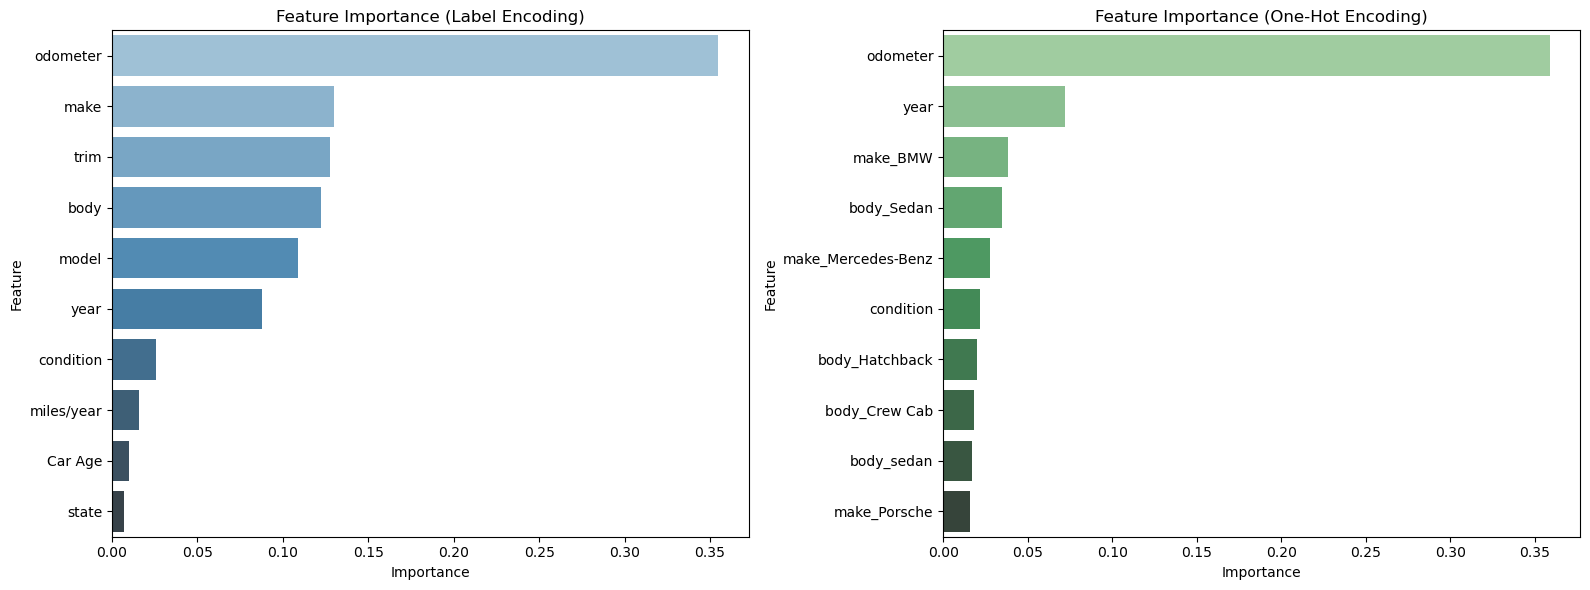

In [122]:
# Plotting feature importance of two models
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.barplot(x='Importance', y='Feature', data=top_feats_rf_le, ax=axes[0], palette='Blues_d')
axes[0].set_title('Feature Importance (Label Encoding)')

sns.barplot(x='Importance', y='Feature', data=top_feats_rf, ax=axes[1], palette='Greens_d')
axes[1].set_title('Feature Importance (One-Hot Encoding)')

plt.tight_layout()
plt.show()

### Summary of Results:
- **Both models agree that 'odometer' is the primary driver of prediction**. The main distinction lies in how the importance of categorical features is represented. Label Encoding consolidates the importance of a categorical feature into a single bar, giving a high-level view. One-Hot Encoding breaks this down, revealing which specific categories within a feature (e.g., 'make_BMW' vs. 'make_Mercedes-Benz') are most influential. For understanding the granular impact of specific sub-categories, One-Hot Encoding's feature importance is more insightful, while Label Encoding provides a quick overview of the overall impact of a categorical variable.
- Both models generally show a good fit, with many predicted values aligning closely with the actual selling prices, especially at lower and moderate price ranges (up to approximately USD 75,000 - USD 100,000). The data points cluster tightly around the ideal fit line in this range, indicating accurate predictions for the majority of the observations.
- Comparing the two encoding techniques:
    - RF (Label Encoded) - <font color="blue">Blue Dots</font>: This model appears to have a slightly wider spread of predictions, especially noticeable at lower actual selling prices where some blue dots are further from the ideal line, both above and below. This suggests it might be slightly less precise or prone to larger errors for some predictions.
    - RF (One-Hot Encoded) - <font color="green">Green Dots</font>: This model seems to show a slightly tighter clustering around the ideal fit line, particularly in the lower to middle price ranges. While it also exhibits the underprediction trend at higher prices, it might be marginally more consistent in its predictions across the board compared to the label-encoded model.

### Model improvements:
- More Data for High-Value Cars: If possible, acquire more data points for vehicles in the higher price ranges. Machine learning models often struggle with classes or ranges that are underrepresented in the training data.
- Implement hyperparameters tuning and cross-validation
- Alternative Tree-Based Models: Experiment with other powerful gradient boosting frameworks:
    - XGBoost: Known for its speed and performance.
    - LightGBM: Often faster than XGBoost, especially on large datasets.
    - CatBoost: Handles categorical features internally, which might be very beneficial.